# Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods (Week 1)

## Introduction / Business Problem

## Background
### Choose the address of Toronto Center (i.e. Toronto City Hall) to define are there any business opportunities to open a new coffee shop at the below address:
### Address: 100 Queen St W, Toronto, ON M5H 2N2, Canada
### The steps as below:
### 1. Import the Libraries
### 2. Import Postal code data from Wikipedia and data cleaning ==> Output: df_selected_gp
### 3. Geocoder Python package using http://cocl.us/Geospatial_data to obtain the geo data ==> Output: geo_data and merged_data
### 4a. Explore Toronto in high level ==> Output: The merge_data summary by boroughs and neighborhoods and geograpical coordiate of the Toronto City Center
### 4b. Create a map of Toronto with neighborhoods superimposed to visualize Toronto City ==> Output: map_toronto
### 5. Define Foursquare Credentials and Version for API to explore 'Coffee Shop' in Toronto ==> Output: The bar chart
### 6. Clustering neighbourhood  to identify the potential neighbourhood that still can accommodate a new coffee shop ==> Output: Result by cluster number of coffee shops available within the cluster
### 7. Understanding the area based on clusters with the fewer coffee shop (potential new coffee shop area), perform analysis from the map by plotting existing coffee shop nearby and distance from City Center ==> Output: map_coffee_toronto
### 8. Based on the Visualization map - map_coffee_toronto to conduct more detail analysis ==> Output: Report (separate pdf)

### 1. Import the Libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import lxml.html as lh
import bs4 as bs
import urllib.request

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas import json_normalize
import json # library to handle JSON files

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

! pip install folium
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


### 2. Import Postal code data from Wikipedia and data cleaning ==> Output: df_selected_gp

In [2]:
#Getting the Postal code data from Wikipedia from below URL for cluster the Neighbourhood
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
res = requests.get(url)

soup = bs.BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))

In [3]:
data.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
#Exclude data field Borough with not assigned value (NaN)
df_selected = data[data['Borough'] != 'Not assigned']

In [5]:
# Merge Neighbourhood with same Postal Code & Borough
df_selected_gp = df_selected.groupby(['Postal Code','Borough'], as_index=False).agg(','.join) 

In [6]:
#Replacing values in Neighbourhood field with Borough where Neighbourhood is not assigned
df_selected_gp['Neighbourhood'] = np.where(df_selected_gp['Neighbourhood'] == 'Not assigned', df_selected_gp['Borough'], df_selected_gp['Neighbourhood'])

In [7]:
#Shape of Dataframe - df_selected_gp2
df_selected_gp.shape

(103, 3)

In [8]:
df_selected_gp.head() ### Output of Part 2

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### 3. Geocoder Python package using http://cocl.us/Geospatial_data to obtain the geo data ==> Output: geo_data and merged_data

In [9]:
# Getting the data from the Geo Data
geo_url = "http://cocl.us/Geospatial_data"
geo_data = pd.read_csv(geo_url)

In [10]:
#Shape of Dataframe - geo_data
geo_data.shape

(103, 3)

In [11]:
# Renaming the columns
geo_data.columns = ['Postal Code', 'Latitude', 'Longitude']

In [12]:
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
#Merging dataframes from part 2 df_selected_gp with Postal code data from Wikipedia with geo_data
merged_data = pd.merge(df_selected_gp, geo_data, on='Postal Code')

In [14]:
merged_data.shape

(103, 5)

In [15]:
merged_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### 4a. Explore Toronto in high level ==> Output: The merge_data summary by boroughs and neighborhoods and geograpical coordiate of the Toronto City Center

In [16]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(merged_data['Borough'].unique()),
        merged_data.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [17]:
address = '100 Queen St W, Toronto, ON M5H 2N2, Canada' #City Center (City Hall) address

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City Center (City Hall) are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City Center (City Hall) are 43.6536032, -79.38400547469666.


### 4b. Create a map of Toronto with neighborhoods superimposed to visualize Toronto City ==> Output: map_toronto

In [18]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(merged_data['Latitude'], merged_data['Longitude'], merged_data['Borough'], merged_data['Neighbourhood']):
    label = '{}, {}'.format(merged_data, borough) 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### 5. Define Foursquare Credentials and Version for API to explore 'Coffee Shop' in Toronto ==> Output: The bar chart

In [19]:
### In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>foursquare_agent</em>, as shown below.

CLIENT_ID = 'VDTIGKOQ155NQU5QONOPYTASGVVM53IFI1RJQ03DJGNJJLVE' # your Foursquare ID
CLIENT_SECRET = 'TOARIBO1SI5SRNSKSEF5B1VQD5PYIUAEO1IVN0CQG11MYIPT' # your Foursquare Secret
ACCESS_TOKEN = '5QI15HOCBXA212YWDMTF5R0LLQFKIDF5V1I1JYZD5PEPAEXJ' # your FourSquare Access Token
VERSION = '20210206'
LIMIT = 500
radius = 500
print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: VDTIGKOQ155NQU5QONOPYTASGVVM53IFI1RJQ03DJGNJJLVE
CLIENT_SECRET:TOARIBO1SI5SRNSKSEF5B1VQD5PYIUAEO1IVN0CQG11MYIPT


In [20]:
### Explore specific venue category - Coffee Shop
search_query = 'Coffee Shop'
print('Explore '+ search_query + ' in Toronto!')

Explore Coffee Shop in Toronto!


In [21]:
### API URL by using my credentials
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=VDTIGKOQ155NQU5QONOPYTASGVVM53IFI1RJQ03DJGNJJLVE&client_secret=TOARIBO1SI5SRNSKSEF5B1VQD5PYIUAEO1IVN0CQG11MYIPT&ll=43.6536032,-79.38400547469666&oauth_token=5QI15HOCBXA212YWDMTF5R0LLQFKIDF5V1I1JYZD5PEPAEXJ&v=20210206&query=Coffee Shop&radius=500&limit=500'

In [22]:
### Get the json data file result for transformation
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '601eb597faf02272393803b6'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '5d493dc5735c2d0007bc3966',
    'name': 'Bluestone Lane Queen Station Coffee Shop',
    'location': {'address': '2 Queen Street East',
     'lat': 43.6525684,
     'lng': -79.3790471,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.6525684,
       'lng': -79.3790471}],
     'distance': 415,
     'postalCode': 'M5C 3G5',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['2 Queen Street East',
      'Toronto ON M5C 3G5',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d16d941735',
      'name': 'Café',
      'pluralName': 'Cafés',
      'shortName': 'Café',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1612625303',
    'hasPerk

In [23]:
### Get relevant part of JSON and transform it into a pandas dataframe
### Assign relevant part of JSON to venues
venues = results['response']['venues']

# Tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood,venuePage.id
0,5d493dc5735c2d0007bc3966,Bluestone Lane Queen Station Coffee Shop,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1612625303,False,2 Queen Street East,43.652568,-79.379047,"[{'label': 'display', 'lat': 43.6525684, 'lng'...",415,M5C 3G5,CA,Toronto,ON,Canada,"[2 Queen Street East, Toronto ON M5C 3G5, Canada]",NaN,NaN,NaN
1,4c6bd9de69b4ef3b4d51474e,GRIP 6th Floor Coffee Shop,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1612625303,False,179 John St.,43.651035,-79.391256,"[{'label': 'display', 'lat': 43.65103493678703...",650,M5T 1X4,CA,Toronto,ON,Canada,"[179 John St. (at Queen St.), Toronto ON M5T 1...",at Queen St.,NaN,NaN
2,59f784dd28122f14f9d5d63d,HotBlack Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1612625303,False,245 Queen Street West,43.650364,-79.388669,"[{'label': 'display', 'lat': 43.65036434800487...",520,M5V 1Z4,CA,Toronto,ON,Canada,"[245 Queen Street West (at St Patrick St), Tor...",at St Patrick St,Entertainment District,463001529
3,4baa31def964a52037523ae3,Coffee office,[],v-1612625303,False,350 Bay St - 7th Floor,43.649498,-79.386479,"[{'label': 'display', 'lat': 43.649498, 'lng':...",498,NaN,CA,Toronto,ON,Canada,"[350 Bay St - 7th Floor, Toronto ON, Canada]",NaN,NaN,NaN
4,4b0aaa8ef964a520272623e3,Timothy's World Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1612625303,False,"483 Bay St, Bell Trinity Square",43.653436,-79.382314,"[{'label': 'display', 'lat': 43.653436, 'lng':...",137,M5G 2C9,CA,Toronto,ON,Canada,"[483 Bay St, Bell Trinity Square (Bell Trinity...",Bell Trinity Square,NaN,NaN


In [24]:
# Keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# Clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Bluestone Lane Queen Station Coffee Shop,Café,2 Queen Street East,43.652568,-79.379047,"[{'label': 'display', 'lat': 43.6525684, 'lng'...",415,M5C 3G5,CA,Toronto,ON,Canada,"[2 Queen Street East, Toronto ON M5C 3G5, Canada]",NaN,NaN,5d493dc5735c2d0007bc3966
1,GRIP 6th Floor Coffee Shop,Coffee Shop,179 John St.,43.651035,-79.391256,"[{'label': 'display', 'lat': 43.65103493678703...",650,M5T 1X4,CA,Toronto,ON,Canada,"[179 John St. (at Queen St.), Toronto ON M5T 1...",at Queen St.,NaN,4c6bd9de69b4ef3b4d51474e
2,HotBlack Coffee,Coffee Shop,245 Queen Street West,43.650364,-79.388669,"[{'label': 'display', 'lat': 43.65036434800487...",520,M5V 1Z4,CA,Toronto,ON,Canada,"[245 Queen Street West (at St Patrick St), Tor...",at St Patrick St,Entertainment District,59f784dd28122f14f9d5d63d
3,Coffee office,None,350 Bay St - 7th Floor,43.649498,-79.386479,"[{'label': 'display', 'lat': 43.649498, 'lng':...",498,NaN,CA,Toronto,ON,Canada,"[350 Bay St - 7th Floor, Toronto ON, Canada]",NaN,NaN,4baa31def964a52037523ae3
4,Timothy's World Coffee,Coffee Shop,"483 Bay St, Bell Trinity Square",43.653436,-79.382314,"[{'label': 'display', 'lat': 43.653436, 'lng':...",137,M5G 2C9,CA,Toronto,ON,Canada,"[483 Bay St, Bell Trinity Square (Bell Trinity...",Bell Trinity Square,NaN,4b0aaa8ef964a520272623e3
5,Coffee Court,Coffee Shop,NaN,43.652355,-79.381650,"[{'label': 'display', 'lat': 43.652355, 'lng':...",235,NaN,CA,NaN,NaN,Canada,[Canada],NaN,NaN,57b1d07b498e85a00ac8baa8
6,Timothy's World Coffee,Coffee Shop,425 University Ave,43.654270,-79.387448,"[{'label': 'display', 'lat': 43.65427, 'lng': ...",287,M5G 1T6,CA,Toronto,ON,Canada,"[425 University Ave (Dundas), Toronto ON M5G 1...",Dundas,NaN,53e8acc4498ee294fb100183
7,Timothy's World Coffee,Coffee Shop,401 Bay St.,43.652135,-79.381172,"[{'label': 'display', 'lat': 43.65213455850074...",280,M5H 2Y4,CA,Toronto,ON,Canada,"[401 Bay St. (at Richmond St. W), Toronto ON M...",at Richmond St. W,NaN,4baa9f6cf964a520817a3ae3
8,Square Shop!,Pop-Up Shop,202 Queen Street West,43.650440,-79.388885,"[{'label': 'display', 'lat': 43.65044, 'lng': ...",527,M5V 1Z2,CA,Toronto,ON,Canada,"[202 Queen Street West (St Patrick), Toronto O...",St Patrick,NaN,59e636b7840fc2686ffb51f1
9,BRIKA Popup Shop at The Hudson Bay,Miscellaneous Shop,NaN,43.652608,-79.383581,"[{'label': 'display', 'lat': 43.65260822309432...",115,NaN,CA,NaN,NaN,Canada,[Canada],NaN,NaN,5255f0bc11d2121363221aa3


In [25]:
### list of Coffee Shop name in Toronto
dataframe_filtered.name 

0      Bluestone Lane Queen Station Coffee Shop
1                    GRIP 6th Floor Coffee Shop
2                               HotBlack Coffee
3                                 Coffee office
4                        Timothy's World Coffee
5                                  Coffee Court
6                        Timothy's World Coffee
7                        Timothy's World Coffee
8                                  Square Shop!
9            BRIKA Popup Shop at The Hudson Bay
10                    Coffee Antidote 9th Floor
11                       Timothy's World Coffee
12                           Jays Shop at Sears
13                       Timothy's World Coffee
14                                      F5 Shop
15                                   Sushi Shop
16                              The barber shop
17                        Seattle's Best Coffee
18                       Treats Coffee Emporium
19            ModLifter - Shop Style & Lift Up!
20                               Bulldog

In [26]:
### Check are there any chain coffee shop
dataframe_filtered.name.value_counts()

Timothy's World Coffee                       5
Love Shop                                    1
Smokes'N Coffee                              1
Coffee Court                                 1
HotBlack Coffee                              1
Square Shop!                                 1
F5 Shop                                      1
Starbucks                                    1
Future Shop ASW                              1
Gift Shop At St Michael's Hospital           1
Seattle's Best Coffee                        1
The Hippie Grow Shop                         1
Urbana Coffee Co.                            1
Coffee Antidote 9th Floor                    1
BRIKA Popup Shop at The Hudson Bay           1
Coffee office                                1
Onyx Barber Shop                             1
Fresh Start Coffee Company                   1
Sushi Shop                                   1
Bulldog Coffee                               1
The barber shop                              1
Cozy Coffee  

### Let's visualize the Coffee Shop that are nearby City Hall (City Center)

In [28]:
# Generate coffee shop map centred around the City Hall
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) 

# Add a red circle marker to represent the City Hall
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='City Hall',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# Add the Coffee Shop as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

In [29]:
dataframe_filtered.head() ### preview the filtered dataframe sample

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Bluestone Lane Queen Station Coffee Shop,Café,2 Queen Street East,43.652568,-79.379047,"[{'label': 'display', 'lat': 43.6525684, 'lng'...",415,M5C 3G5,CA,Toronto,ON,Canada,"[2 Queen Street East, Toronto ON M5C 3G5, Canada]",NaN,NaN,5d493dc5735c2d0007bc3966
1,GRIP 6th Floor Coffee Shop,Coffee Shop,179 John St.,43.651035,-79.391256,"[{'label': 'display', 'lat': 43.65103493678703...",650,M5T 1X4,CA,Toronto,ON,Canada,"[179 John St. (at Queen St.), Toronto ON M5T 1...",at Queen St.,NaN,4c6bd9de69b4ef3b4d51474e
2,HotBlack Coffee,Coffee Shop,245 Queen Street West,43.650364,-79.388669,"[{'label': 'display', 'lat': 43.65036434800487...",520,M5V 1Z4,CA,Toronto,ON,Canada,"[245 Queen Street West (at St Patrick St), Tor...",at St Patrick St,Entertainment District,59f784dd28122f14f9d5d63d
3,Coffee office,None,350 Bay St - 7th Floor,43.649498,-79.386479,"[{'label': 'display', 'lat': 43.649498, 'lng':...",498,NaN,CA,Toronto,ON,Canada,"[350 Bay St - 7th Floor, Toronto ON, Canada]",NaN,NaN,4baa31def964a52037523ae3
4,Timothy's World Coffee,Coffee Shop,"483 Bay St, Bell Trinity Square",43.653436,-79.382314,"[{'label': 'display', 'lat': 43.653436, 'lng':...",137,M5G 2C9,CA,Toronto,ON,Canada,"[483 Bay St, Bell Trinity Square (Bell Trinity...",Bell Trinity Square,NaN,4b0aaa8ef964a520272623e3


In [30]:
dataframe_filtered.columns ### preview the filtered dataframe columns

Index(['name', 'categories', 'address', 'lat', 'lng', 'labeledLatLngs',
       'distance', 'postalCode', 'cc', 'city', 'state', 'country',
       'formattedAddress', 'crossStreet', 'neighborhood', 'id'],
      dtype='object')

### Extract data with Postal Code not null only

In [31]:
# Creating bool series False for NaN values
bool_series = pd.notnull(dataframe_filtered["postalCode"])
 
# Displayed data only Postal Code not null (NaN)
dataframe_filtered2 = dataframe_filtered[bool_series]

In [32]:
# Extract the postalCode to 3 charater Postal Code
dataframe_filtered2['postalCode'].str[0:3] 

0     M5C
1     M5T
2     M5V
4     M5G
6     M5G
7     M5H
8     M5V
12    M5B
13    M5B
14    M4G
15    M5X
17    M5G
19    M4Y
20    M5H
21    M5G
22    M5V
23    M5C
24    M5T
25    M5G
26    M5B
28    M5G
29    M5V
30    M5T
31    M5G
32    M3B
33    M5B
35    M5B
37    M5G
41    M5B
42    M5H
43    M4N
45    M5H
46    M5V
Name: postalCode, dtype: object

In [33]:
# Update postalCode to 3 charater Postal Code
dataframe_filtered2['postalCode'] = dataframe_filtered2['postalCode'].str[0:3] 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [34]:
dataframe_filtered2.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Bluestone Lane Queen Station Coffee Shop,Café,2 Queen Street East,43.652568,-79.379047,"[{'label': 'display', 'lat': 43.6525684, 'lng'...",415,M5C,CA,Toronto,ON,Canada,"[2 Queen Street East, Toronto ON M5C 3G5, Canada]",NaN,NaN,5d493dc5735c2d0007bc3966
1,GRIP 6th Floor Coffee Shop,Coffee Shop,179 John St.,43.651035,-79.391256,"[{'label': 'display', 'lat': 43.65103493678703...",650,M5T,CA,Toronto,ON,Canada,"[179 John St. (at Queen St.), Toronto ON M5T 1...",at Queen St.,NaN,4c6bd9de69b4ef3b4d51474e
2,HotBlack Coffee,Coffee Shop,245 Queen Street West,43.650364,-79.388669,"[{'label': 'display', 'lat': 43.65036434800487...",520,M5V,CA,Toronto,ON,Canada,"[245 Queen Street West (at St Patrick St), Tor...",at St Patrick St,Entertainment District,59f784dd28122f14f9d5d63d
4,Timothy's World Coffee,Coffee Shop,"483 Bay St, Bell Trinity Square",43.653436,-79.382314,"[{'label': 'display', 'lat': 43.653436, 'lng':...",137,M5G,CA,Toronto,ON,Canada,"[483 Bay St, Bell Trinity Square (Bell Trinity...",Bell Trinity Square,NaN,4b0aaa8ef964a520272623e3
6,Timothy's World Coffee,Coffee Shop,425 University Ave,43.654270,-79.387448,"[{'label': 'display', 'lat': 43.65427, 'lng': ...",287,M5G,CA,Toronto,ON,Canada,"[425 University Ave (Dundas), Toronto ON M5G 1...",Dundas,NaN,53e8acc4498ee294fb100183


In [35]:
### Create the coffee dataframe with Postal Code, Coffee Shop Name, Address, Latitude, Longitude
coffee = dataframe_filtered2[['postalCode','name','address','lat','lng']]
coffee

,postalCode,name,address,lat,lng
0,M5C,Bluestone Lane Queen Station Coffee Shop,2 Queen Street East,43.652568,-79.379047
1,M5T,GRIP 6th Floor Coffee Shop,179 John St.,43.651035,-79.391256
2,M5V,HotBlack Coffee,245 Queen Street West,43.650364,-79.388669
4,M5G,Timothy's World Coffee,"483 Bay St, Bell Trinity Square",43.653436,-79.382314
6,M5G,Timothy's World Coffee,425 University Ave,43.654270,-79.387448
7,M5H,Timothy's World Coffee,401 Bay St.,43.652135,-79.381172
8,M5V,Square Shop!,202 Queen Street West,43.650440,-79.388885
12,M5B,Jays Shop at Sears,290 Yonge St.,43.655823,-79.380491
13,M5B,Timothy's World Coffee,Yonge,43.656700,-79.379941
14,M4G,F5 Shop,1559 Bayview Ave,43.654211,-79.385715


In [36]:
### Rename the coffee dataframe column name 'postalCode' to 'Postal Code'
coffee.rename(columns = {'postalCode':'Postal Code'}, inplace = True) 
coffee

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Postal Code,name,address,lat,lng
0,M5C,Bluestone Lane Queen Station Coffee Shop,2 Queen Street East,43.652568,-79.379047
1,M5T,GRIP 6th Floor Coffee Shop,179 John St.,43.651035,-79.391256
2,M5V,HotBlack Coffee,245 Queen Street West,43.650364,-79.388669
4,M5G,Timothy's World Coffee,"483 Bay St, Bell Trinity Square",43.653436,-79.382314
6,M5G,Timothy's World Coffee,425 University Ave,43.654270,-79.387448
7,M5H,Timothy's World Coffee,401 Bay St.,43.652135,-79.381172
8,M5V,Square Shop!,202 Queen Street West,43.650440,-79.388885
12,M5B,Jays Shop at Sears,290 Yonge St.,43.655823,-79.380491
13,M5B,Timothy's World Coffee,Yonge,43.656700,-79.379941
14,M4G,F5 Shop,1559 Bayview Ave,43.654211,-79.385715


In [37]:
### Merging the coffee shop data (coffee) and postal code data (df_selected_gp) by using the key 'Postal Code' from both dataframe
merged_coffee_data = pd.merge(coffee, df_selected_gp, on='Postal Code')

In [38]:
merged_coffee_data.shape

(33, 7)

In [39]:
merged_coffee_data.head()

,Postal Code,name,address,lat,lng,Borough,Neighbourhood
0,M5C,Bluestone Lane Queen Station Coffee Shop,2 Queen Street East,43.652568,-79.379047,Downtown Toronto,St. James Town
1,M5C,Dineen Coffee,140 Yonge St,43.650497,-79.378765,Downtown Toronto,St. James Town
2,M5T,GRIP 6th Floor Coffee Shop,179 John St.,43.651035,-79.391256,Downtown Toronto,"Kensington Market, Chinatown, Grange Park"
3,M5T,The Library Specialty Coffee,281 Dundas St West,43.654413,-79.390902,Downtown Toronto,"Kensington Market, Chinatown, Grange Park"
4,M5T,Coffee Exchange,109 McCaul St,43.653730,-79.390983,Downtown Toronto,"Kensington Market, Chinatown, Grange Park"


In [40]:
### Analyza the number of coffee shop in each Neighbourhood
coffeeshop_freq = merged_coffee_data['Neighbourhood'].value_counts()
coffeeshop_freq

Central Bay Street                                                                                            8
Garden District, Ryerson                                                                                      6
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport    5
Richmond, Adelaide, King                                                                                      4
Kensington Market, Chinatown, Grange Park                                                                     3
St. James Town                                                                                                2
Leaside                                                                                                       1
Don Mills                                                                                                     1
Church and Wellesley                                                                                    

Text(0, 0.5, 'Number of coffee shop')

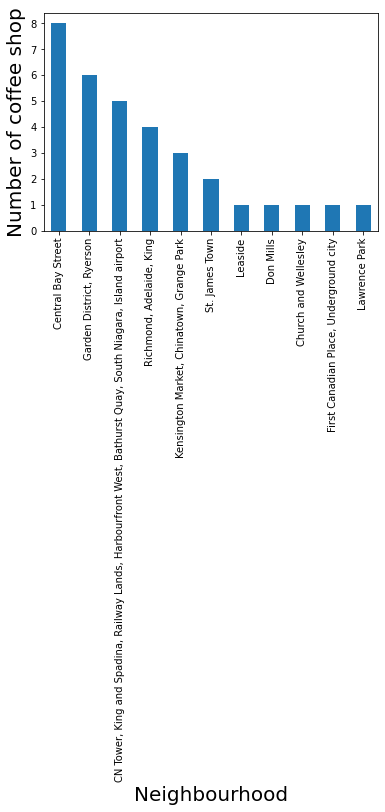

In [41]:
### Number of coffee shop per Neighbourhood in Bar chart
coffeeshop_freq.plot.bar()
plt.xlabel("Neighbourhood", fontsize=20)
plt.ylabel("Number of coffee shop", fontsize=20)

### 6. Clustering neighbourhood  to identify the potential neighbourhood that still can accommodate a new coffee shop ==> Output: Result by cluster number of coffee shops available within the cluster

In [42]:
# Import k-means from clustering stage
from sklearn.cluster import KMeans

In [43]:
cat = pd.get_dummies(merged_coffee_data['Postal Code']) # one hot encoding with get_dummies()
df_01 = pd.concat([merged_coffee_data[['Neighbourhood']], cat], axis=1) # combine neighbourhood & category tables
df_01.head()

,Neighbourhood,M3B,M4G,M4N,M4Y,M5B,M5C,M5G,M5H,M5T,M5V,M5X
0,St. James Town,0,0,0,0,0,1,0,0,0,0,0
1,St. James Town,0,0,0,0,0,1,0,0,0,0,0
2,"Kensington Market, Chinatown, Grange Park",0,0,0,0,0,0,0,0,1,0,0
3,"Kensington Market, Chinatown, Grange Park",0,0,0,0,0,0,0,0,1,0,0
4,"Kensington Market, Chinatown, Grange Park",0,0,0,0,0,0,0,0,1,0,0


In [44]:
df_02 = df_01.drop('Neighbourhood', axis=1)

n_group = 6 # we will group neighbourhoods into 6 clusters

# run k-means clustering
kmeans = KMeans(n_clusters=n_group, random_state=0).fit(df_02)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 2, 2, 5, 5, 5, 5, 5], dtype=int32)

In [45]:
# Add clustering labels
df_01.insert(1, 'label', kmeans.labels_)

In [46]:
df_01.head() # 'label' generated from k-means included in data frame

,Neighbourhood,label,M3B,M4G,M4N,M4Y,M5B,M5C,M5G,M5H,M5T,M5V,M5X
0,St. James Town,0,0,0,0,0,0,1,0,0,0,0,0
1,St. James Town,0,0,0,0,0,0,1,0,0,0,0,0
2,"Kensington Market, Chinatown, Grange Park",2,0,0,0,0,0,0,0,0,1,0,0
3,"Kensington Market, Chinatown, Grange Park",2,0,0,0,0,0,0,0,0,1,0,0
4,"Kensington Market, Chinatown, Grange Park",2,0,0,0,0,0,0,0,0,1,0,0


In [47]:
neighbourhood_coffee_data = pd.merge(merged_data, df_01, on='Neighbourhood')
neighbourhood_coffee_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,label,M3B,M4G,M4N,M4Y,M5B,M5C,M5G,M5H,M5T,M5V,M5X
0,M3B,North York,Don Mills,43.745906,-79.352188,0,1,0,0,0,0,0,0,0,0,0,0
1,M3C,North York,Don Mills,43.725900,-79.340923,0,1,0,0,0,0,0,0,0,0,0,0
2,M4G,East York,Leaside,43.709060,-79.363452,0,0,1,0,0,0,0,0,0,0,0,0
3,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0,0,1,0,0,0,0,0,0,0,0
4,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,0,0,0,1,0,0,0,0,0,0,0


In [48]:
neighbourhood_coffee_data.shape

(34, 17)

In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_group)
ys = [i + x + (i*x)**2 for i in range(n_group)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbourhood_coffee_data['Latitude'], neighbourhood_coffee_data['Longitude'], neighbourhood_coffee_data['Neighbourhood'], neighbourhood_coffee_data['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining Clusters

In [50]:
### Cluster 1
neighbourhood_coffee_data.loc[neighbourhood_coffee_data['label'] == 0]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,label,M3B,M4G,M4N,M4Y,M5B,M5C,M5G,M5H,M5T,M5V,M5X
0,M3B,North York,Don Mills,43.745906,-79.352188,0,1,0,0,0,0,0,0,0,0,0,0
1,M3C,North York,Don Mills,43.725900,-79.340923,0,1,0,0,0,0,0,0,0,0,0,0
2,M4G,East York,Leaside,43.709060,-79.363452,0,0,1,0,0,0,0,0,0,0,0,0
3,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0,0,1,0,0,0,0,0,0,0,0
4,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,0,0,0,1,0,0,0,0,0,0,0
11,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,0,0,0,0,0,1,0,0,0,0,0
12,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,0,0,0,0,0,1,0,0,0,0,0
33,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,0,0,0,0,0,0,0,0,0,0,0,1


In [51]:
### Cluster 2
neighbourhood_coffee_data.loc[neighbourhood_coffee_data['label'] == 1]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,label,M3B,M4G,M4N,M4Y,M5B,M5C,M5G,M5H,M5T,M5V,M5X
21,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1,0,0,0,0,0,0,0,1,0,0,0
22,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1,0,0,0,0,0,0,0,1,0,0,0
23,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1,0,0,0,0,0,0,0,1,0,0,0
24,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1,0,0,0,0,0,0,0,1,0,0,0


In [52]:
### Cluster 3
neighbourhood_coffee_data.loc[neighbourhood_coffee_data['label'] == 2]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,label,M3B,M4G,M4N,M4Y,M5B,M5C,M5G,M5H,M5T,M5V,M5X
25,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,2,0,0,0,0,0,0,0,0,1,0,0
26,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,2,0,0,0,0,0,0,0,0,1,0,0
27,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,2,0,0,0,0,0,0,0,0,1,0,0


In [53]:
### Cluster 4
neighbourhood_coffee_data.loc[neighbourhood_coffee_data['label'] == 3]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,label,M3B,M4G,M4N,M4Y,M5B,M5C,M5G,M5H,M5T,M5V,M5X
13,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,0,0,0,0,0,0,1,0,0,0,0
14,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,0,0,0,0,0,0,1,0,0,0,0
15,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,0,0,0,0,0,0,1,0,0,0,0
16,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,0,0,0,0,0,0,1,0,0,0,0
17,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,0,0,0,0,0,0,1,0,0,0,0
18,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,0,0,0,0,0,0,1,0,0,0,0
19,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,0,0,0,0,0,0,1,0,0,0,0
20,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,0,0,0,0,0,0,1,0,0,0,0


In [54]:
### Cluster 5
neighbourhood_coffee_data.loc[neighbourhood_coffee_data['label'] == 4]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,label,M3B,M4G,M4N,M4Y,M5B,M5C,M5G,M5H,M5T,M5V,M5X
5,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,0,0,0,0,1,0,0,0,0,0,0
6,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,0,0,0,0,1,0,0,0,0,0,0
7,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,0,0,0,0,1,0,0,0,0,0,0
8,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,0,0,0,0,1,0,0,0,0,0,0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,0,0,0,0,1,0,0,0,0,0,0
10,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,0,0,0,0,1,0,0,0,0,0,0


In [55]:
neighbourhood_coffee_data.loc[neighbourhood_coffee_data['label'] == 5]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,label,M3B,M4G,M4N,M4Y,M5B,M5C,M5G,M5H,M5T,M5V,M5X
28,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.39442,5,0,0,0,0,0,0,0,0,0,1,0
29,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.39442,5,0,0,0,0,0,0,0,0,0,1,0
30,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.39442,5,0,0,0,0,0,0,0,0,0,1,0
31,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.39442,5,0,0,0,0,0,0,0,0,0,1,0
32,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.39442,5,0,0,0,0,0,0,0,0,0,1,0


### 7. Understanding the area based on clusters with the fewer coffee shop (potential new coffee shop area), perform analysis from the map by plotting existing coffee shop nearby and distance from City Center ==> Output: map_coffee_toronto

In [56]:
### Existing coffee shop location in the Richmond, Adelaide, King Neighbourhood
exist_shop_1 = merged_coffee_data[merged_coffee_data['Neighbourhood'] == 'Richmond, Adelaide, King']
exist_shop_1

,Postal Code,name,address,lat,lng,Borough,Neighbourhood
18,M5H,Timothy's World Coffee,401 Bay St.,43.652135,-79.381172,Downtown Toronto,"Richmond, Adelaide, King"
19,M5H,Bulldog Coffee,111 Richmond St W,43.650319,-79.383831,Downtown Toronto,"Richmond, Adelaide, King"
20,M5H,Fahrenheit Coffee,111 Richmond St,43.650361,-79.383767,Downtown Toronto,"Richmond, Adelaide, King"
21,M5H,Shopsy's Deli,96 Richmond St. W,43.651057,-79.383009,Downtown Toronto,"Richmond, Adelaide, King"


In [58]:
### Trim down the existing coffee shop location in the Richmond, Adelaide, King Neighbourhood to 4 col only
exist_shop_1 = exist_shop_1[['name','Neighbourhood','lat','lng']]
exist_shop_1

,name,Neighbourhood,lat,lng
18,Timothy's World Coffee,"Richmond, Adelaide, King",43.652135,-79.381172
19,Bulldog Coffee,"Richmond, Adelaide, King",43.650319,-79.383831
20,Fahrenheit Coffee,"Richmond, Adelaide, King",43.650361,-79.383767
21,Shopsy's Deli,"Richmond, Adelaide, King",43.651057,-79.383009


In [59]:
### Existing coffee shop location in the Kensington Market, Chinatown, Grange Park
exist_shop_2 = merged_coffee_data[merged_coffee_data['Neighbourhood'] == 'Kensington Market, Chinatown, Grange Park']
exist_shop_2

,Postal Code,name,address,lat,lng,Borough,Neighbourhood
2,M5T,GRIP 6th Floor Coffee Shop,179 John St.,43.651035,-79.391256,Downtown Toronto,"Kensington Market, Chinatown, Grange Park"
3,M5T,The Library Specialty Coffee,281 Dundas St West,43.654413,-79.390902,Downtown Toronto,"Kensington Market, Chinatown, Grange Park"
4,M5T,Coffee Exchange,109 McCaul St,43.653730,-79.390983,Downtown Toronto,"Kensington Market, Chinatown, Grange Park"


In [60]:
### Trim down the existing coffee shop location in the Kensington Market, Chinatown, Grange Park to 4 col only
exist_shop_2 = exist_shop_2[['name','Neighbourhood','lat','lng']]
exist_shop_2

,name,Neighbourhood,lat,lng
2,GRIP 6th Floor Coffee Shop,"Kensington Market, Chinatown, Grange Park",43.651035,-79.391256
3,The Library Specialty Coffee,"Kensington Market, Chinatown, Grange Park",43.654413,-79.390902
4,Coffee Exchange,"Kensington Market, Chinatown, Grange Park",43.653730,-79.390983


In [61]:
### Existing coffee shop location in both destination
exist_shop = [exist_shop_1, exist_shop_2]
exist_shop

[                      name             Neighbourhood        lat        lng
 18  Timothy's World Coffee  Richmond, Adelaide, King  43.652135 -79.381172
 19          Bulldog Coffee  Richmond, Adelaide, King  43.650319 -79.383831
 20       Fahrenheit Coffee  Richmond, Adelaide, King  43.650361 -79.383767
 21           Shopsy's Deli  Richmond, Adelaide, King  43.651057 -79.383009,
                            name                              Neighbourhood  \
 2    GRIP 6th Floor Coffee Shop  Kensington Market, Chinatown, Grange Park   
 3  The Library Specialty Coffee  Kensington Market, Chinatown, Grange Park   
 4               Coffee Exchange  Kensington Market, Chinatown, Grange Park   
 
          lat        lng  
 2  43.651035 -79.391256  
 3  43.654413 -79.390902  
 4  43.653730 -79.390983  ]

In [62]:
### Transform into dataframe
existing = pd.concat(exist_shop) 
existing

,name,Neighbourhood,lat,lng
18,Timothy's World Coffee,"Richmond, Adelaide, King",43.652135,-79.381172
19,Bulldog Coffee,"Richmond, Adelaide, King",43.650319,-79.383831
20,Fahrenheit Coffee,"Richmond, Adelaide, King",43.650361,-79.383767
21,Shopsy's Deli,"Richmond, Adelaide, King",43.651057,-79.383009
2,GRIP 6th Floor Coffee Shop,"Kensington Market, Chinatown, Grange Park",43.651035,-79.391256
3,The Library Specialty Coffee,"Kensington Market, Chinatown, Grange Park",43.654413,-79.390902
4,Coffee Exchange,"Kensington Market, Chinatown, Grange Park",43.653730,-79.390983


In [63]:
### Create potential new shop neighbourhood dataframe
new_shop = {'Neighbourhood': ['Richmond, Adelaide, King','Kensington Market, Chinatown, Grange Park'],
            'Latitude': [43.650571, 43.653206],
            'Longitude':[-79.384568, -79.400049]
        }

df_new_shop = pd.DataFrame(new_shop, columns = ['Neighbourhood', 'Latitude', 'Longitude'])
df_new_shop

,Neighbourhood,Latitude,Longitude
0,"Richmond, Adelaide, King",43.650571,-79.384568
1,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049


In [67]:
# Create Coffee map of Toronto using latitude and longitude values
map_coffee_toronto = folium.Map(location=[latitude, longitude], zoom_start=15)

# Add City Center (City Hall) to the map in red
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='City Hall',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.7
).add_to(map_coffee_toronto)

# Add New points to the map in blue
for lat, lng, neighborhood in zip(df_new_shop['Latitude'], df_new_shop['Longitude'], df_new_shop['Neighbourhood']):
    label = '{}, {}'.format(df_new_shop, borough) 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_coffee_toronto)  
    
# Add Existing shops to map in green
for lat, lng, neighborhood in zip(existing['lat'], existing['lng'], existing['Neighbourhood']):
    label = '{}, {}'.format(existing, borough) 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_coffee_toronto)  
    
map_coffee_toronto

### 8. Based on the Visualization map - map_coffee_toronto to conduct more detail analysis ==> Output: Report (separate pdf)

### Investor can refer to the map in two potential neighbourhood and the nearby coffee shops and other localities (e.g. Restaurants, Bar, Art Center, etc.), then can plan to next steps on the analysis of the neighbourhood rental (from the web) or neighbourhood income (from the web) for further decision-making on the new coffee shop location. Details can refer to the report (.pdf).